In [5]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [6]:
data = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [7]:
data

,DateTime,Room_Temp(�C),T1(�C),T2(�C),T3(�C),T4(�C),T5(�C),T6(�C),T8(�C),T9(�C),...,Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),WS_Temperature(�C),WS_SolarRadiation(w/m�),WS_WindDirection_Slope(w/m�),Thermal_Operation_Mode,Total_Consumption(W),Total_Production(W)
0,2021-04-27 10:59:00,25.80,39.7642,38.9047,30.2405,29.2547,30.6289,23.8826,21.1263,43.1663,...,-9.0,5400.0,249.0,0.0,19.0,415.9,424.842,NaN,0,0
1,2021-04-27 11:00:00,25.80,40.1910,39.9168,30.2350,29.2187,30.5723,23.7865,21.1465,43.1815,...,-9.0,5655.0,274.0,0.0,19.0,415.9,437.187,NaN,0,0
2,2021-04-27 11:01:00,25.80,46.5653,40.5658,30.2460,29.1893,30.5332,23.6677,21.1420,43.1830,...,-9.0,5777.0,276.0,0.0,19.0,415.9,455.580,NaN,0,0
3,2021-04-27 11:02:00,25.80,49.1767,42.5260,30.2463,29.1720,30.5095,23.6100,21.1353,43.1763,...,-9.0,6116.0,276.0,0.0,19.0,415.9,493.072,NaN,0,0
4,2021-04-27 11:03:00,25.80,46.0035,44.3658,30.2517,29.1640,30.4855,23.5548,21.1123,43.1638,...,-9.0,5049.0,276.0,0.0,19.0,415.9,410.092,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224874,2021-11-04 16:24:00,26.70,44.6310,39.6540,30.6040,29.2290,29.8980,100.0000,19.7600,51.4850,...,183.0,959.0,29.0,374.0,17.0,13.4,82.673,0.0,635,1516
224875,2021-11-04 16:25:00,26.70,44.5840,39.5610,30.5810,29.2070,29.8790,100.0000,19.7520,51.4730,...,174.0,912.0,29.0,374.0,17.0,13.4,78.300,0.0,634,1460
224876,2021-11-04 16:26:00,26.70,44.4540,39.4660,30.5750,29.2010,29.8740,100.0000,19.7520,51.4760,...,167.0,874.0,29.0,374.0,17.0,13.4,74.750,0.0,634,1415
224877,2021-11-04 16:27:00,26.70,44.3810,39.3810,30.5520,29.1830,29.8660,100.0000,19.7520,51.4840,...,161.0,848.0,29.0,375.0,17.0,13.4,72.533,0.0,1423,1384


In [8]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Room_Temp(�C)', 'T1(�C)', 'T2(�C)', 'T3(�C)', 'T4(�C)', 'T5(�C)', 'T6(�C)', 'T8(�C)', 'T9(�C)', 'T10(�C)', 'T12(�C)', 'F1(lpm)', 'F2(lpm)', 'F3(lpm)', 'F4(lpm)', 'ESS_Power(W)', 'Pvt_Supply(W)', 'Pv_Supply(W)', 'Heatpump_Load(W)', 'FuelCell_Supply(W)', 'WS_Temperature(�C)', 'WS_SolarRadiation(w/m�)', 'WS_WindDirection_Slope(w/m�)', 'Thermal_Operation_Mode', 'Total_Consumption(W)', 'Total_Production(W)']


In [9]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['Slope_solar_radiation(w/m2)'] = data['WS_WindDirection_Slope(w/m�)']
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']
df_kepsh1['ESS(W)'] = data['ESS_Power(W)']*(-1)

df_kepsh1.head()


,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W)
0,2021-04-27 10:59:00,5400.0,0.0,424.842,0.0,249.0,0,0,-0.0
1,2021-04-27 11:00:00,5655.0,0.0,437.187,0.0,274.0,0,0,-0.0
2,2021-04-27 11:01:00,5777.0,0.0,455.580,0.0,276.0,0,0,-0.0
3,2021-04-27 11:02:00,6116.0,0.0,493.072,0.0,276.0,0,0,-0.0
4,2021-04-27 11:03:00,5049.0,0.0,410.092,0.0,276.0,0,0,-0.0


In [10]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [11]:
df_kepsh1 = df_kepsh1[df_kepsh1['Cons_kepsh1(W)']< 10000]

In [12]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-09-13 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-11-03 23:59:00') ]

In [13]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65365 entries, 158524 to 223889
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         65365 non-null  datetime64[ns]
 1   PV_kepsh1(W)                 65365 non-null  float64       
 2   PVT_kepsh1(W)                65365 non-null  float64       
 3   Slope_solar_radiation(w/m2)  65365 non-null  float64       
 4   FC(W)                        65365 non-null  float64       
 5   HP_kepsh1(W)                 65365 non-null  float64       
 6   Cons_kepsh1(W)               65365 non-null  int64         
 7   Prod_kepsh1(W)               65365 non-null  int64         
 8   ESS(W)                       65361 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 5.0 MB


In [14]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [15]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [16]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [17]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [18]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [19]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [20]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65365 entries, 158524 to 223889
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Time                         65365 non-null  datetime64[ns]
 1   PV_kepsh1(W)                 65365 non-null  float64       
 2   PVT_kepsh1(W)                65365 non-null  float64       
 3   Slope_solar_radiation(w/m2)  65365 non-null  float64       
 4   FC(W)                        65365 non-null  float64       
 5   HP_kepsh1(W)                 65365 non-null  float64       
 6   Cons_kepsh1(W)               65365 non-null  float64       
 7   Prod_kepsh1(W)               65365 non-null  float64       
 8   ESS(W)                       65361 non-null  float64       
 9   Cons_acc_kepsh1(Wh)          65365 non-null  float64       
 10  Prod_acc_kepsh1(Wh)          65365 non-null  float64       
 11  PV_acc_kepsh1(Wh)            65365 

In [21]:
df_kepsh1.to_csv('./211109_kepsh1.csv')

In [22]:
df_kepsh1

,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W),ESS(W),Cons_acc_kepsh1(Wh),...,PVT_acc_kepsh1(Wh),FC_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
158524,2021-09-13 00:00:00,0.0,9.0,0.0,0.0,29.0,677.0,9.0,-0.0,1.128333e+01,...,0.150000,0.000000,9.0,1.500000e-01,1.0,0.013294,1.000000,0.013294,0.013294,0.506647
158525,2021-09-13 00:03:00,0.0,9.0,0.0,0.0,29.0,674.0,9.0,-0.0,2.251667e+01,...,0.300000,0.000000,9.0,3.000000e-01,1.0,0.013353,1.000000,0.013323,0.013323,0.506662
158526,2021-09-13 00:04:00,0.0,9.0,0.0,0.0,29.0,780.0,9.0,-0.0,3.551667e+01,...,0.450000,0.000000,9.0,4.500000e-01,1.0,0.011538,1.000000,0.012670,0.012670,0.506335
158527,2021-09-13 00:05:00,0.0,9.0,0.0,0.0,28.0,806.0,9.0,-0.0,4.895000e+01,...,0.600000,0.000000,9.0,6.000000e-01,1.0,0.011166,1.000000,0.012257,0.012257,0.506129
158528,2021-09-13 00:06:00,0.0,9.0,0.0,0.0,29.0,797.0,9.0,-0.0,6.223333e+01,...,0.750000,0.000000,9.0,7.500000e-01,1.0,0.011292,1.000000,0.012051,0.012051,0.506026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223885,2021-11-03 23:55:00,0.0,0.0,0.0,569.0,29.0,892.0,569.0,-0.0,1.367140e+06,...,83373.283333,164584.933333,569.0,1.367140e+06,1.0,0.637892,0.511999,1.000000,1.953130,0.755999
223886,2021-11-03 23:56:00,0.0,0.0,0.0,568.0,29.0,896.0,568.0,-0.0,1.367155e+06,...,83373.283333,164594.400000,568.0,1.367155e+06,1.0,0.633929,0.512003,1.000000,1.953115,0.756001
223887,2021-11-03 23:57:00,0.0,0.0,0.0,568.0,29.0,897.0,568.0,-0.0,1.367170e+06,...,83373.283333,164603.866667,568.0,1.367170e+06,1.0,0.633222,0.512006,1.000000,1.953101,0.756003
223888,2021-11-03 23:58:00,0.0,0.0,0.0,570.0,29.0,892.0,570.0,-0.0,1.367185e+06,...,83373.283333,164613.366667,570.0,1.367185e+06,1.0,0.639013,0.512010,1.000000,1.953086,0.756005


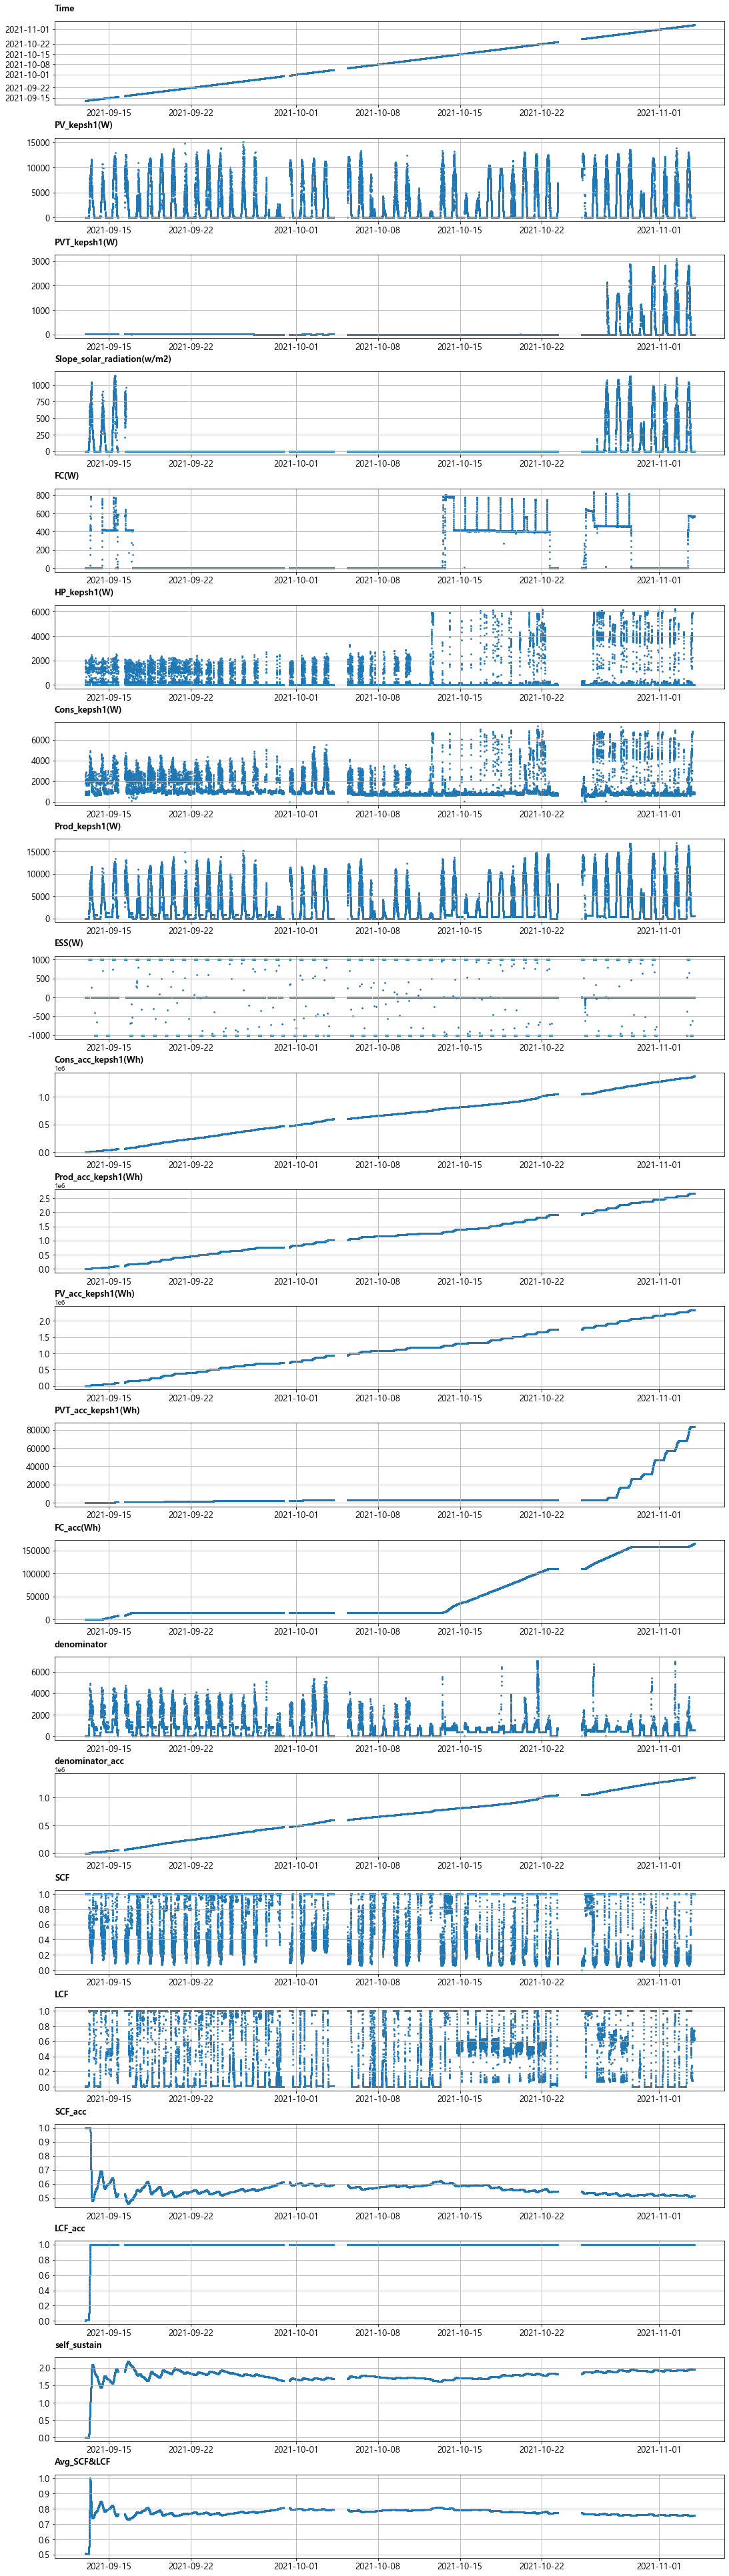

In [23]:
fig, ax = plt.subplots(figsize=(18,70))


for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kepsh1.columns[i]
    plt.scatter(x=df_kepsh1['Time'], y=df_kepsh1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line graph

In [24]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [25]:
df_kepsh1.to_csv('./211109_kepsh1.csv')

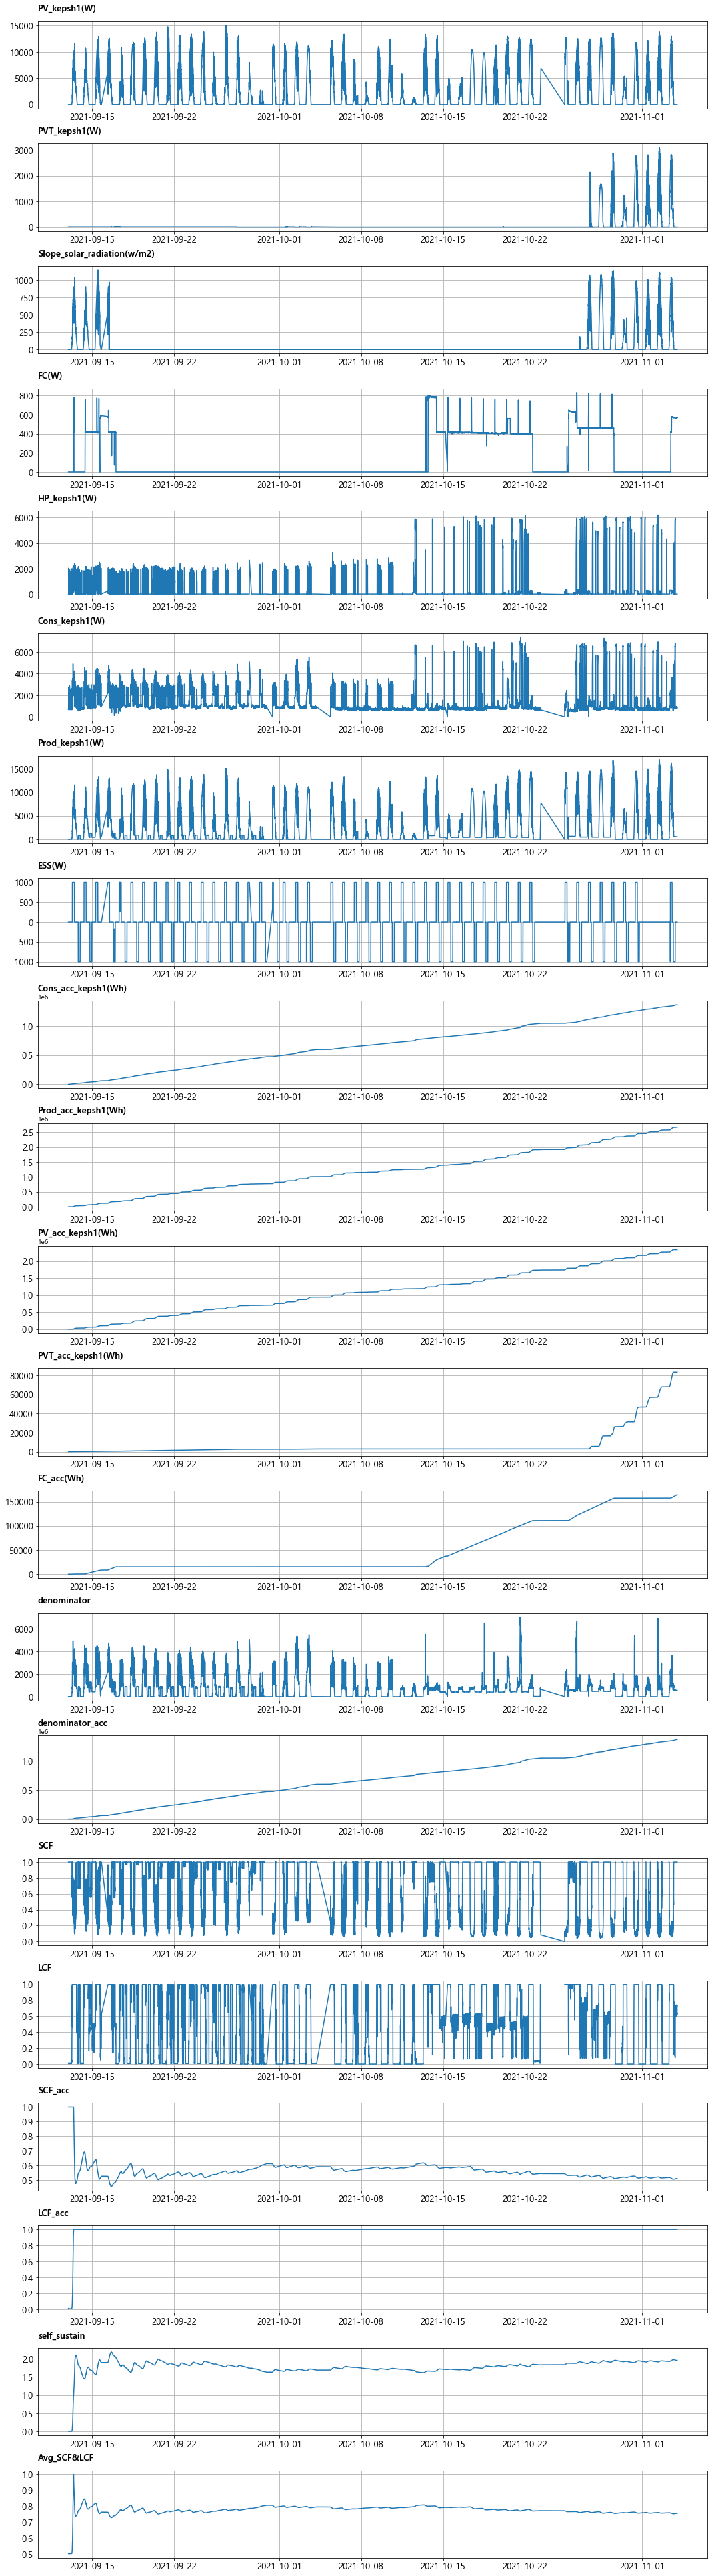

In [26]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kepsh1.columns[i]
    plt.plot(df_kepsh1[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()